In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from datetime import timedelta

from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import CompareMeans

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
user_engagement_df = pd.read_csv('takehome_user_engagement.csv')
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
print('unique user count:', user_engagement_df.user_id.nunique())

unique user count: 8823


In [4]:
len(user_engagement_df)

207917

In [5]:
# convert to datetime format
user_engagement_df.time_stamp = pd.to_datetime(user_engagement_df.time_stamp, format='%Y-%m-%d %H:%M:%S')

In [6]:
def adopted_user_login(df, days=7, user_login=3):
    df['date'] = df.time_stamp.dt.date
    de_dup_df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = de_dup_df['date'].diff(periods=user_login-1)
    return any(passed_days <= timedelta(days=days))

In [7]:

adopted_user_df = user_engagement_df.groupby('user_id').apply(adopted_user_login)
adopted_user_df.name = 'adopted_user'
adopted_user_df

user_id
1        False
2         True
3        False
4        False
5        False
         ...  
11996    False
11997    False
11998    False
11999    False
12000    False
Name: adopted_user, Length: 8823, dtype: bool

In [8]:
adopted_user_df.describe()

count      8823
unique        2
top       False
freq       7167
Name: adopted_user, dtype: object

Now that the login data shows who has been adopted lets look at some of the user data.

In [9]:
users_df = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1", engine='python') #, usecols=cols)
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [10]:
drop_cols = ['name', 'email']
users_df= users_df.drop(columns=drop_cols)
users_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [11]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   creation_source             12000 non-null  object 
 3   last_session_creation_time  8823 non-null   float64
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   org_id                      12000 non-null  int64  
 7   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 750.1+ KB


In [12]:
users_df.invited_by_user_id.fillna(0, inplace=True)


In [13]:
users_df.invited_by_user_id.value_counts()


0.0        5583
10741.0      13
2527.0       12
1525.0       11
2308.0       11
           ... 
7941.0        1
4134.0        1
6101.0        1
129.0         1
594.0         1
Name: invited_by_user_id, Length: 2565, dtype: int64

In [14]:
users_df.org_id.value_counts()


0      319
1      233
2      201
3      168
4      159
      ... 
396      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

In [15]:
# convert to datetime format
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'], format='%Y-%m-%d %H:%M:%S')
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')



In [16]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   creation_source             12000 non-null  object        
 3   last_session_creation_time  8823 non-null   datetime64[ns]
 4   opted_in_to_mailing_list    12000 non-null  int64         
 5   enabled_for_marketing_drip  12000 non-null  int64         
 6   org_id                      12000 non-null  int64         
 7   invited_by_user_id          12000 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 750.1+ KB


In [17]:
users_df.last_session_creation_time.fillna(users_df.creation_time, inplace=True)


In [18]:
# make feture
users_df['usage_age'] = users_df['last_session_creation_time'] - users_df['creation_time']
users_df['usage_age'] = users_df['usage_age'].dt.days


closest_to_now = max([max(users_df['creation_time']), max(users_df['last_session_creation_time'])])
users_df['account_age'] = closest_to_now - users_df['creation_time']
users_df['account_age'] = users_df['account_age'].dt.days



In [19]:
users_df.head()


,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,usage_age,account_age
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,45
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136,203
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,443
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1,381
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5,505


In [20]:
users_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   creation_source             12000 non-null  object        
 3   last_session_creation_time  12000 non-null  datetime64[ns]
 4   opted_in_to_mailing_list    12000 non-null  int64         
 5   enabled_for_marketing_drip  12000 non-null  int64         
 6   org_id                      12000 non-null  int64         
 7   invited_by_user_id          12000 non-null  float64       
 8   usage_age                   12000 non-null  int64         
 9   account_age                 12000 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(6), object(1)
memory usage: 937.6+ KB


In [21]:
users_df = users_df.set_index('object_id')

users_df.index.name = 'user_id'

data_df = pd.concat([users_df, adopted_user_df], axis=1, join='inner')

data_df['adopted_user'] = data_df['adopted_user'].astype(int)


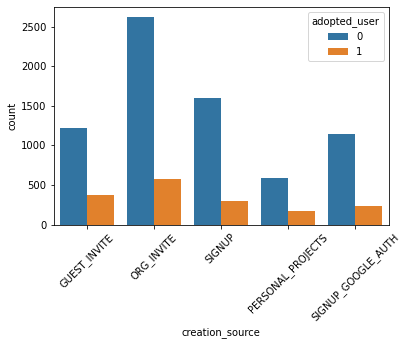

In [22]:
sns.countplot(x='creation_source', data=data_df, hue='adopted_user')
plt.xticks(rotation=45)
plt.show()

In [23]:

crosstab = pd.crosstab(data_df['creation_source'], data_df['adopted_user'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))


chi2 = 41.27933208242451	p = 2.3526508745340972e-08


In [24]:
data_df.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))


creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

In [25]:
def z_test(df, col, target='adopted_user'):
    opted_in = df.loc[df[col]==1, target]
    opted_out = df.loc[df[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))



In [26]:
data_df.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))


opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [27]:
z_test(data_df, 'opted_in_to_mailing_list')


For opted_in_to_mailing_list, z = 0.7029779128148235, p = 0.4820695142048762


In [28]:
data_df.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))


enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

In [29]:
z_test(data_df, 'enabled_for_marketing_drip')


For enabled_for_marketing_drip, z = 0.40292649500940264, p = 0.6870022995069656


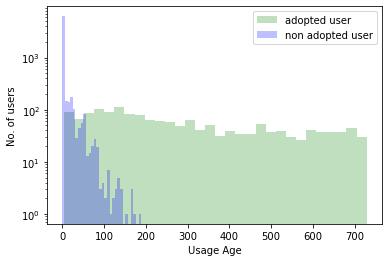

In [30]:


plt.hist(data_df.loc[data_df['adopted_user']==1, 'usage_age'], bins=30, alpha=0.25, color='g', label='adopted user')
plt.hist(data_df.loc[data_df['adopted_user']==0, 'usage_age'], bins=30, alpha=0.25, color='b', label='non adopted user')
plt.yscale('log')
plt.legend()
plt.xlabel('Usage Age')
plt.ylabel('No. of users')
plt.show()

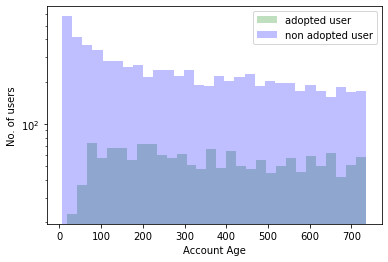

In [31]:

plt.hist(data_df.loc[data_df['adopted_user']==1, 'account_age'], bins=30, alpha=0.25, color='g', label='adopted user')
plt.hist(data_df.loc[data_df['adopted_user']==0, 'account_age'], bins=30, alpha=0.25, color='b', label='non adopted user')
plt.yscale('log')
plt.legend()
plt.xlabel('Account Age')
plt.ylabel('No. of users')
plt.show()

In [32]:
creation_source = pd.get_dummies(data_df['creation_source'], drop_first=True)


In [33]:
final_df = pd.concat([data_df, creation_source], axis=1).drop('creation_source', axis=1)
final_df


,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,usage_age,account_age,adopted_user,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,,,,
1,2014-04-22 03:53:30,2014-04-22 03:53:30,1,0,11,10803.0,0,45,0,0,0,0,0
2,2013-11-15 03:45:04,2014-03-31 03:45:04,0,0,1,316.0,136,203,1,1,0,0,0
3,2013-03-19 23:14:52,2013-03-19 23:14:52,0,0,94,1525.0,0,443,0,1,0,0,0
4,2013-05-21 08:09:28,2013-05-22 08:09:28,0,0,1,5151.0,1,381,0,0,0,0,0
5,2013-01-17 10:14:20,2013-01-22 10:14:20,0,0,193,5240.0,5,505,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11996,2013-09-06 06:14:15,2013-09-06 06:14:15,0,0,89,8263.0,0,273,0,1,0,0,0
11997,2013-01-10 18:28:37,2013-01-15 18:28:37,0,0,200,0.0,5,511,0,0,0,0,1
11998,2014-04-27 12:45:16,2014-04-27 12:45:16,1,1,83,8074.0,0,40,0,0,0,0,0


In [34]:
final_df.columns

Index(['creation_time', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'usage_age', 'account_age', 'adopted_user',
       'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [35]:
feature_columns = [
    'opted_in_to_mailing_list', 
    'enabled_for_marketing_drip', 
    'org_id',
    'invited_by_user_id', 
    'usage_age', 
    'account_age', 
    'ORG_INVITE', 
    'PERSONAL_PROJECTS',
    'SIGNUP', 
    'SIGNUP_GOOGLE_AUTH'
]

In [36]:
X = final_df[feature_columns]
y = final_df.adopted_user

In [37]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.fit_transform(X)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=43)

Random Forest

In [41]:
params = {'n_estimators': range(2, 500, 1)}


model = RandomForestClassifier(random_state=43, class_weight='balanced')

clf = GridSearchCV(model, params)
clf.fit(X_train, y_train)


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=43),
             param_grid={'n_estimators': range(2, 500)})

In [43]:

print('Parameters:', clf.best_params_)
best_params = clf.best_params_
print('Score:', clf.best_score_)


Parameters: {'n_estimators': 115}
Score: 0.9659978123508551


In [44]:
model = RandomForestClassifier(random_state=43, class_weight='balanced', n_estimators=best_params['n_estimators'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9551223934723482
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1792
           1       0.90      0.85      0.88       414

    accuracy                           0.96      2206
   macro avg       0.94      0.91      0.92      2206
weighted avg       0.95      0.96      0.95      2206



In [46]:
importances = pd.Series(model.feature_importances_, index=final_df[feature_columns].columns)
importances = importances.sort_values(ascending=False)
print(importances)


usage_age                     0.847408
account_age                   0.066620
org_id                        0.044880
invited_by_user_id            0.023441
opted_in_to_mailing_list      0.003919
enabled_for_marketing_drip    0.003328
ORG_INVITE                    0.003225
SIGNUP_GOOGLE_AUTH            0.002724
SIGNUP                        0.002543
PERSONAL_PROJECTS             0.001912
dtype: float64


This is going to sound simple but usage age, time last login minus account creation time, is the most important feature. Basicly the more the user uses the software the more likely they are to become an active user. Continuing to remind users to login in should increase retention as a starting point.